Desenvolvimento de uma Estratégia Evolutiva e Algoritmo Genético para a determinação do ponto de mínimo global das seguinte função: Rastringin

Formula de Rastringin:
f(x) = 10d + Σ (xi² - 10 * cos(2πxi))


- Domínio típico: xi ∈ [-5.12, 5.12]
- Mínimo global:
𝑓(𝑥)=0, que ocorre quando todos os xi = 0
- Características: A função é altamente multimodal, o que significa que ela possui uma grande quantidade de mínimos locais. No entanto, esses mínimos seguem um padrão regular em uma paisagem que se assemelha a uma "caixa de ovos", com o mínimo global localizado no centro.


## Algoritmo genético

In [ ]:
from __future__ import annotations
import numpy as np
import pandas as pd
from dataclasses import dataclass, field
from typing import Callable, List, Tuple, Optional, Dict, Any
import math
import time

In [ ]:
D = 30                     # Dimensão do vetor solução
LOWER_BOUND = -5.12        # Limite inferior do domínio da Rastrigin
UPPER_BOUND =  5.12        # Limite superior do domínio da Rastrigin


Definimos a função Rastrigin e ajustamos o domínio de busca, que para a Rastrigin é tipicamente [-5.12, 5.12].

In [ ]:
def rastrigin(x: np.ndarray) -> float:
    """
    Função Rastrigin.
    O mínimo global é 0, em x_i = 0 para todo i.
    """
    x = np.asarray(x, dtype=float)
    d = x.size
    return 10 * d + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))

# Função objetivo a ser usada pelos algoritmos
objective_function = rastrigin

In [ ]:
# Função para garantir que os vetores permaneçam no domínio
def clamp_vector(v: np.ndarray, low=LOWER_BOUND, high=UPPER_BOUND) -> np.ndarray:
    return np.clip(v, low, high)

def clamp_inplace(x: np.ndarray, low: float, high: float):
    np.clip(x, low, high, out=x)

In [ ]:
# --- Operadores do GA
def tournament_select(pop: np.ndarray, fitness: np.ndarray, k: int, rng: np.random.Generator) -> np.ndarray:
    idxs = rng.choice(pop.shape[0], size=k, replace=False)
    best_idx = idxs[np.argmin(fitness[idxs])]
    return pop[best_idx]

def crossover_aritmetico(p1: np.ndarray, p2: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    alpha = rng.random()
    return alpha * p1 + (1 - alpha) * p2

def mutacao_gaussiana_inplace(x: np.ndarray, p_mut_gene: float, sigma: float, low: float, high: float, rng: np.random.Generator) -> None:
    d = x.size
    mask = rng.random(d) < p_mut_gene
    if not np.any(mask):
        return
    x[mask] += rng.normal(loc=0.0, scale=sigma, size=mask.sum())
    clamp_inplace(x, low, high)

O parâmetro sigma_mut (força da mutação) foi ajustado já que a Rastrigin tem vales de mínimo muito estreitos, então uma mutação menor e mais precisa (sigma_mut = 0.1) tende a funcionar melhor.

In [ ]:
# --- Loop Principal do GA (adaptado para usar a função objetivo e limites corretos) ---
def run_ga(
  d: int = D,
  pop_size: int = 150,
  max_evals: int = 100_000,
  p_crossover: float = 0.9,
  p_mut_gene: float | None = None,
  sigma_mut: float = 0.1,  # PARÂMETRO AJUSTADO PARA RASTRIGIN
  elitism: int = 2,
  torneio_k: int = 3,
  seed: int | None = None,
  verbose: bool = True,
) -> Dict[str, Any]:

    if p_mut_gene is None:
        p_mut_gene = 1.0 / d

    rng = np.random.default_rng(seed)
    pop = rng.uniform(low=LOWER_BOUND, high=UPPER_BOUND, size=(pop_size, d))
    fitness = np.array([objective_function(ind) for ind in pop])
    evals = pop_size

    best_idx = int(np.argmin(fitness))
    best_f = float(fitness[best_idx])

    start_time = time.time()
    generation = 0

    while evals < max_evals:
        elite_indices = np.argsort(fitness)[:elitism]
        elite = pop[elite_indices].copy()
        elite_fitness = fitness[elite_indices].copy()

        offspring_list = []
        while len(offspring_list) < pop_size - elitism:
            p1 = tournament_select(pop, fitness, torneio_k, rng)
            p2 = tournament_select(pop, fitness, torneio_k, rng)
            child = p1.copy()
            if rng.random() < p_crossover:
                child = crossover_aritmetico(p1, p2, rng)
            mutacao_gaussiana_inplace(child, p_mut_gene, sigma_mut, LOWER_BOUND, UPPER_BOUND, rng)
            offspring_list.append(child)

        offspring = np.vstack(offspring_list)
        offspring_fitness = np.array([objective_function(ind) for ind in offspring])
        evals += offspring_fitness.size

        pop = np.vstack([elite, offspring])
        fitness = np.concatenate([elite_fitness, offspring_fitness])

        current_best_idx = int(np.argmin(fitness))
        best_f = float(fitness[current_best_idx])

        if verbose and generation % 50 == 0:
            print(f"GA Gen {generation:4d} | evals={evals:6d} | best_f={best_f:.6f}")

        generation += 1
        if best_f <= 1e-8:
            break

    elapsed = time.time() - start_time
    print(f"GA Finalizou. Melhor Fitness: {best_f:.8f} em {elapsed:.2f}s")
    return {'best_f': best_f}

## Estratégia Evolutiva


Autoadaptação:
  sigma_i' = sigma_i * exp( τ' * N(0,1)_global + τ * N(0,1)_i )
  onde:
      τ' = 1 / sqrt(2d)
      τ  = 1 / sqrt(2 * sqrt(d))

Vantagem: Passe de mutação ajusta-se dinamicamente (explora no começo, refina depois).

In [ ]:
#inicialização pais
# mu: num pais
# d : dim
# domain_low/high : limites
# init_sigma_frac : fração do range para iniciar sigma

#retorna: posições e desvios padrão inciais

def initialize_es(mu: int, d: int,
                  domain_low: float, domain_high: float,
                  init_sigma_frac: float,
                  rng: np.random.Generator):
    X = rng.uniform(domain_low, domain_high, size=(mu, d))
    range_width = domain_high - domain_low
    SIGMA = np.full((mu, d), init_sigma_frac * range_width, dtype=float)
    return X, SIGMA


In [ ]:
def recombine_discrete(parents_idx, X, SIGMA, rng):
    parents_x = X[parents_idx]
    parents_s = SIGMA[parents_idx]
    num_parents, d = parents_x.shape
    child_x = np.empty(d, dtype=float)
    child_sigma = np.empty(d, dtype=float)
    for j in range(d):
        p = rng.integers(0, num_parents)
        child_x[j] = parents_x[p, j]
        child_sigma[j] = parents_s[p, j]
    return child_x, child_sigma

In [ ]:
def mutate_strategy_and_object(child_x, child_sigma, tau_prime, tau, rng, domain_low, domain_high):
    d = child_x.shape[0]
    global_noise = rng.normal()
    gene_noise = rng.normal(size=d)
    child_sigma = child_sigma * np.exp(tau_prime * global_noise + tau * gene_noise)
    child_sigma = np.clip(child_sigma, 1e-8, (domain_high - domain_low) * 0.2) # Limitar sigma
    child_x += child_sigma * gene_noise # Mutação do objeto usa gene_noise diferente da estratégia
    clamp_inplace(child_x, domain_low, domain_high)
    return child_x, child_sigma

In [ ]:
def run_es(
    d: int = D,
    mu: int = 30,
    lamb: int = 200,
    max_evals: int = 100_000,
    init_sigma_frac: float = 0.2, # PARÂMETRO AJUSTADO PARA RASTRIGIN
    recomb_parents: int = 2,
    plus_strategy: bool = False,
    seed: int | None = None,
    verbose: bool = True,
) -> Dict[str, Any]:

    rng = np.random.default_rng(seed)
    tau_prime = 1 / np.sqrt(2 * d)
    tau = 1 / np.sqrt(2 * np.sqrt(d))

    X, SIGMA = initialize_es(mu, d, LOWER_BOUND, UPPER_BOUND, init_sigma_frac, rng)
    fitness = np.array([objective_function(ind) for ind in X])
    evals = mu
    best_f = float(np.min(fitness))

    start_time = time.time()
    generation = 0

    while evals < max_evals:
        offspring_x = []
        offspring_sigma = []

        for _ in range(lamb):
            parents_idx = rng.choice(mu, size=recomb_parents, replace=False)
            child_x, child_sigma = recombine_discrete(parents_idx, X, SIGMA, rng)
            child_x, child_sigma = mutate_strategy_and_object(
                child_x, child_sigma, tau_prime, tau, rng, LOWER_BOUND, UPPER_BOUND
            )
            offspring_x.append(child_x)
            offspring_sigma.append(child_sigma)

        OFF_X = np.vstack(offspring_x)
        OFF_SIGMA = np.vstack(offspring_sigma)
        OFF_fit = np.array([objective_function(ind) for ind in OFF_X])
        evals += OFF_fit.size

        if plus_strategy:
            comb_X = np.vstack([X, OFF_X])
            comb_SIGMA = np.vstack([SIGMA, OFF_SIGMA])
            comb_fit = np.concatenate([fitness, OFF_fit])
            order = np.argsort(comb_fit)
            X = comb_X[order[:mu]]
            SIGMA = comb_SIGMA[order[:mu]]
            fitness = comb_fit[order[:mu]]
        else:
            order = np.argsort(OFF_fit)
            X = OFF_X[order[:mu]]
            SIGMA = OFF_SIGMA[order[:mu]]
            fitness = OFF_fit[order[:mu]]

        best_f = fitness[0] # Como está ordenado, o melhor é o primeiro

        if verbose and generation % 20 == 0:
            mean_sigma = float(np.mean(SIGMA))
            print(f"ES Gen {generation:4d} | evals={evals:6d} | best_f={best_f:.6f} | mean_sigma={mean_sigma:.4f}")

        generation += 1
        if best_f <= 1e-8:
            break

    elapsed = time.time() - start_time
    print(f"ES Finalizou. Melhor Fitness: {best_f:.8f} em {elapsed:.2f}s")
    return {'best_f': best_f}


In [ ]:
if __name__ == "__main__":
    print("--- Executando Algoritmo Genético para Rastrigin ---")
    ga_results = run_ga(seed=2024, max_evals=100000)
    print("-" * 50)

    print("\n--- Executando Estratégia Evolutiva para Rastrigin ---")
    # A ES (mu, lambda) costuma ser mais eficaz para Rastrigin
    es_results = run_es(seed=2024, max_evals=100000, plus_strategy=False)
    print("-" * 50)

    print("\nResultados Finais:")
    print(f"  GA Melhor Fitness: {ga_results['best_f']:.8f}")
    print(f"  ES Melhor Fitness: {es_results['best_f']:.8f}")

--- Executando Algoritmo Genético para Rastrigin ---
GA Gen    0 | evals=   298 | best_f=288.724610
GA Gen   50 | evals=  7698 | best_f=61.573058
GA Gen  100 | evals= 15098 | best_f=27.033263
GA Gen  150 | evals= 22498 | best_f=26.069043
GA Gen  200 | evals= 29898 | best_f=25.913262
GA Gen  250 | evals= 37298 | best_f=25.882242
GA Gen  300 | evals= 44698 | best_f=25.876514
GA Gen  350 | evals= 52098 | best_f=25.872089
GA Gen  400 | evals= 59498 | best_f=25.870495
GA Gen  450 | evals= 66898 | best_f=25.869969
GA Gen  500 | evals= 74298 | best_f=25.869614
GA Gen  550 | evals= 81698 | best_f=25.869527
GA Gen  600 | evals= 89098 | best_f=25.869431
GA Gen  650 | evals= 96498 | best_f=25.869364
GA Finalizou. Melhor Fitness: 25.86933692 em 9.98s
--------------------------------------------------

--- Executando Estratégia Evolutiva para Rastrigin ---
ES Gen    0 | evals=   230 | best_f=419.010990 | mean_sigma=1.8193
ES Gen   20 | evals=  4230 | best_f=228.399968 | mean_sigma=0.4226
ES Gen   4

--- Executando algoritmos com a lógica original ---
--- Execução finalizada. Gerando gráficos... ---


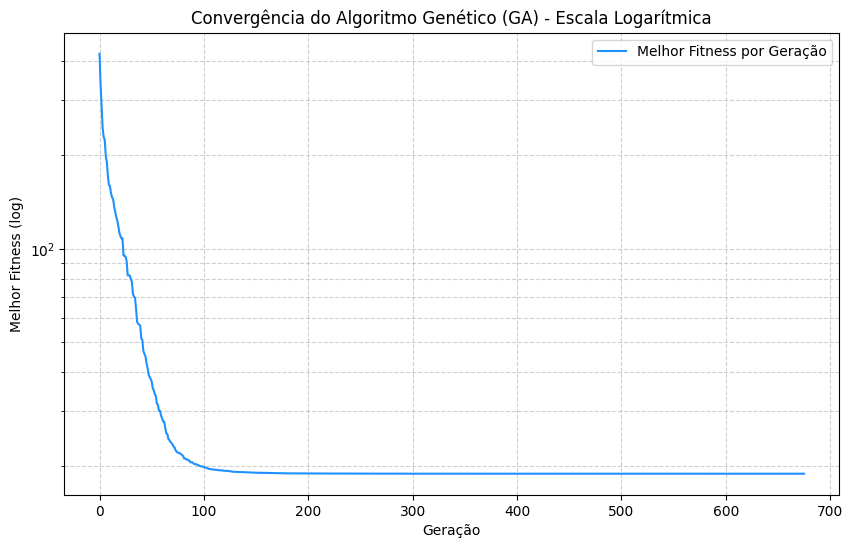

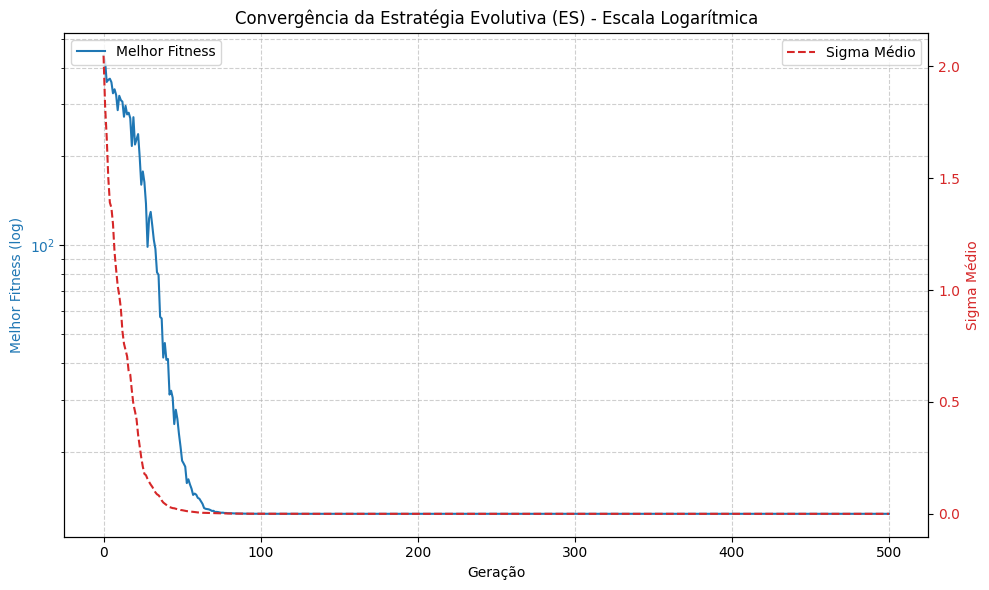

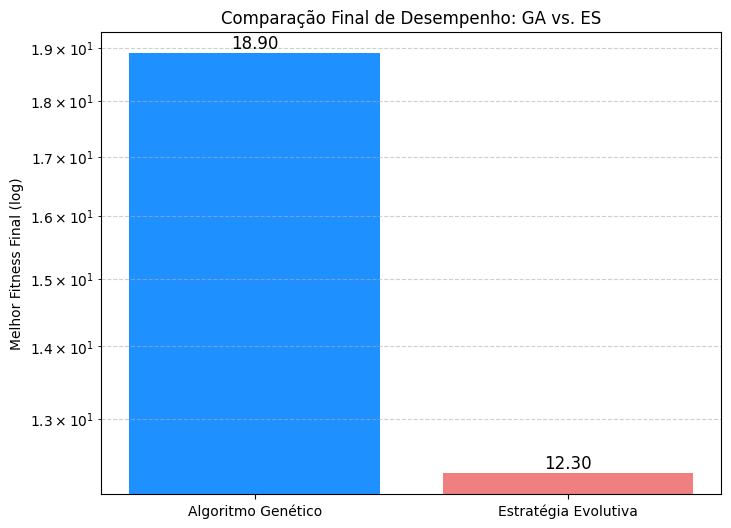


Resultados Finais com a Lógica Original:
  GA Melhor Fitness: 18.90456568
  ES Melhor Fitness: 12.30038185


In [ ]:
# ==============================================================================
# SEÇÃO 1: IMPORTAÇÕES E CONFIGURAÇÕES GLOBAIS
# ==============================================================================
from __future__ import annotations
import numpy as np
import time
from typing import Dict, Any
import matplotlib.pyplot as plt

# Parâmetros globais do problema
D = 30                     # Dimensão do vetor solução
LOWER_BOUND = -5.12        # Limite inferior do domínio da Rastrigin
UPPER_BOUND =  5.12        # Limite superior do domínio da Rastrigin

# ==============================================================================
# SEÇÃO 2: FUNÇÃO OBJETIVO E FUNÇÕES AUXILIARES
# ==============================================================================

def rastrigin(x: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    d = x.size
    return 10 * d + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))

objective_function = rastrigin

def clamp_inplace(x: np.ndarray, low: float, high: float):
    np.clip(x, low, high, out=x)

# ==============================================================================
# SEÇÃO 3: OPERADORES DOS ALGORITMOS (GA e ES)
# ==============================================================================

# --- Operadores do Algoritmo Genético ---
def tournament_select(pop: np.ndarray, fitness: np.ndarray, k: int, rng: np.random.Generator) -> np.ndarray:
    idxs = rng.choice(pop.shape[0], size=k, replace=False)
    best_idx = idxs[np.argmin(fitness[idxs])]
    return pop[best_idx]

def crossover_aritmetico(p1: np.ndarray, p2: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    alpha = rng.random()
    return alpha * p1 + (1 - alpha) * p2

def mutacao_gaussiana_inplace(x: np.ndarray, p_mut_gene: float, sigma: float, low: float, high: float, rng: np.random.Generator) -> None:
    d = x.size
    mask = rng.random(d) < p_mut_gene
    if not np.any(mask):
        return
    x[mask] += rng.normal(loc=0.0, scale=sigma, size=mask.sum())
    clamp_inplace(x, low, high)

# --- Operadores da Estratégia Evolutiva ---
def initialize_es(mu: int, d: int, domain_low: float, domain_high: float, init_sigma_frac: float, rng: np.random.Generator):
    X = rng.uniform(domain_low, domain_high, size=(mu, d))
    range_width = domain_high - domain_low
    SIGMA = np.full((mu, d), init_sigma_frac * range_width, dtype=float)
    return X, SIGMA

def recombine_discrete(parents_idx, X, SIGMA, rng):
    parents_x = X[parents_idx]
    parents_s = SIGMA[parents_idx]
    num_parents, d = parents_x.shape
    child_x = np.empty(d, dtype=float)
    child_sigma = np.empty(d, dtype=float)
    for j in range(d):
        p = rng.integers(0, num_parents)
        child_x[j] = parents_x[p, j]
        child_sigma[j] = parents_s[p, j]
    return child_x, child_sigma

# <<< FUNÇÃO CORRIGIDA PARA BATER COM A LÓGICA ORIGINAL >>>
def mutate_strategy_and_object(child_x, child_sigma, tau_prime, tau, rng, domain_low, domain_high):
    d = child_x.shape[0]
    global_noise = rng.normal()
    gene_noise = rng.normal(size=d) # Ruído gerado uma vez

    # Mutação da estratégia (sigma)
    child_sigma = child_sigma * np.exp(tau_prime * global_noise + tau * gene_noise)
    child_sigma = np.clip(child_sigma, 1e-8, (domain_high - domain_low) * 0.2)

    # Mutação do objeto (x) REUTILIZANDO o mesmo `gene_noise`
    child_x += child_sigma * gene_noise

    clamp_inplace(child_x, domain_low, domain_high)
    return child_x, child_sigma

# ==============================================================================
# SEÇÃO 4: FUNÇÕES PRINCIPAIS DOS ALGORITMOS (COM HISTÓRICO)
# ==============================================================================

def run_ga_with_history(
  d: int = D,
  pop_size: int = 150,
  max_evals: int = 100_000,
  sigma_mut: float = 0.1,
  seed: int | None = None,
) -> Dict[str, Any]:
    p_mut_gene = 1.0 / d
    rng = np.random.default_rng(seed)
    pop = rng.uniform(low=LOWER_BOUND, high=UPPER_BOUND, size=(pop_size, d))
    fitness = np.array([objective_function(ind) for ind in pop])
    evals = pop_size
    best_f = float(np.min(fitness))
    history = [best_f]
    generation = 0
    elitism = 2
    torneio_k = 3

    while evals < max_evals:
        elite_indices = np.argsort(fitness)[:elitism]
        elite_pop = pop[elite_indices].copy()
        elite_fitness = fitness[elite_indices].copy()

        offspring_pop_list = []
        while len(offspring_pop_list) < pop_size - elitism:
            p1 = tournament_select(pop, fitness, torneio_k, rng)
            p2 = tournament_select(pop, fitness, torneio_k, rng)
            child = crossover_aritmetico(p1, p2, rng)
            mutacao_gaussiana_inplace(child, p_mut_gene, sigma_mut, LOWER_BOUND, UPPER_BOUND, rng)
            offspring_pop_list.append(child)

        offspring_pop = np.vstack(offspring_pop_list)
        offspring_fitness = np.array([objective_function(ind) for ind in offspring_pop])
        evals += offspring_fitness.size

        pop = np.vstack([elite_pop, offspring_pop])
        fitness = np.concatenate([elite_fitness, offspring_fitness])

        best_f = float(np.min(fitness))
        history.append(best_f)

        generation += 1
        if best_f <= 1e-8:
            break

    return {'best_f': best_f, 'history': history}

def run_es_with_history(
    d: int = D,
    mu: int = 30,
    lamb: int = 200,
    max_evals: int = 100_000,
    init_sigma_frac: float = 0.2,
    seed: int | None = None,
) -> Dict[str, Any]:
    rng = np.random.default_rng(seed)
    tau_prime = 1 / np.sqrt(2 * d)
    tau = 1 / np.sqrt(2 * np.sqrt(d))
    X, SIGMA = initialize_es(mu, d, LOWER_BOUND, UPPER_BOUND, init_sigma_frac, rng)
    fitness = np.array([objective_function(ind) for ind in X])
    evals = mu
    best_f = float(np.min(fitness))
    history_f = [best_f]
    history_sigma = [float(np.mean(SIGMA))]
    generation = 0

    while evals < max_evals:
        offspring_x, offspring_sigma = [], []
        for _ in range(lamb):
            parents_idx = rng.choice(mu, size=2, replace=False)
            child_x, child_sigma = recombine_discrete(parents_idx, X, SIGMA, rng)
            child_x, child_sigma = mutate_strategy_and_object(
                child_x, child_sigma, tau_prime, tau, rng, LOWER_BOUND, UPPER_BOUND
            )
            offspring_x.append(child_x)
            offspring_sigma.append(child_sigma)

        OFF_X = np.vstack(offspring_x)
        OFF_SIGMA = np.vstack(offspring_sigma)
        OFF_fit = np.array([objective_function(ind) for ind in OFF_X])
        evals += OFF_fit.size

        order = np.argsort(OFF_fit)
        X = OFF_X[order[:mu]]
        SIGMA = OFF_SIGMA[order[:mu]]
        fitness = OFF_fit[order[:mu]]

        best_f = fitness[0]
        history_f.append(best_f)
        history_sigma.append(float(np.mean(SIGMA)))

        generation += 1
        if best_f <= 1e-8:
            break

    return {'best_f': best_f, 'history_f': history_f, 'history_sigma': history_sigma}

# ==============================================================================
# SEÇÃO 5: EXECUÇÃO PRINCIPAL E GERAÇÃO DE GRÁFICOS
# ==============================================================================

if __name__ == "__main__":
    print("--- Executando algoritmos com a lógica original ---")
    ga_results = run_ga_with_history(seed=2024)
    es_results = run_es_with_history(seed=2024)
    print("--- Execução finalizada. Gerando gráficos... ---")

    # Gráfico 1: Convergência do Algoritmo Genético (Log)
    plt.figure(figsize=(10, 6))
    plt.plot(ga_results['history'], label='Melhor Fitness por Geração', color='dodgerblue')
    plt.title('Convergência do Algoritmo Genético (GA) - Escala Logarítmica')
    plt.xlabel('Geração')
    plt.ylabel('Melhor Fitness (log)')
    plt.yscale('log')
    plt.grid(True, which="both", linestyle='--', alpha=0.6)
    plt.legend()
    plt.savefig('ga_convergencia_log.png')
    plt.show()

    # Gráfico 2: Convergência da Estratégia Evolutiva (Log)
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Geração')
    ax1.set_ylabel('Melhor Fitness (log)', color='tab:blue')
    ax1.plot(es_results['history_f'], color='tab:blue', label='Melhor Fitness')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True, which="both", linestyle='--', alpha=0.6)
    ax1.set_yscale('log')
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Sigma Médio', color='tab:red')
    ax2.plot(es_results['history_sigma'], color='tab:red', linestyle='--', label='Sigma Médio')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.legend(loc='upper right')

    plt.title('Convergência da Estratégia Evolutiva (ES) - Escala Logarítmica')
    fig.tight_layout()
    plt.savefig('es_convergencia_log.png')
    plt.show()

    # Gráfico 3: Comparação Final (Log)
    labels = ['Algoritmo Genético', 'Estratégia Evolutiva']
    final_fitness = [ga_results['best_f'], es_results['best_f']]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, final_fitness, color=['dodgerblue', 'lightcoral'])
    plt.ylabel('Melhor Fitness Final (log)')
    plt.title('Comparação Final de Desempenho: GA vs. ES')
    plt.yscale('log')

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center', fontsize=12)

    plt.grid(True, which="both", axis='y', linestyle='--', alpha=0.6)
    plt.savefig('comparacao_final_log.png')
    plt.show()

    print("\nResultados Finais com a Lógica Original:")
    print(f"  GA Melhor Fitness: {ga_results['best_f']:.8f}")
    print(f"  ES Melhor Fitness: {es_results['best_f']:.8f}")